# Using Amazon SageMaker to Clone Driving Behavior
## Introduction
This Notebook is a prototype for a Level 300-400 re:Invent 2018 Hackathon where participants will perform the following:

1. Drive a vehicle on a mock track using a [Self-Driving Car Simulator](https://github.com/udacity/self-driving-car-sim) to capture the vehicle's telemetry.
2. Create a Machine Learning (ML) Pipeline, using the telemetry data, to clone the driving behavior as part of a Deep Learning model.
3. Deploy the behavioral cloning model to a production SageMaker Inference Endpoint.
4. Use the Endpoint to autonomously drive the vehicle around a second mock track.

In [1]:
# Suggested Libraries for conda_mxnet
import warnings
import zipfile
import os
#from tqdm import tqdm_notebook
import boto3
import sagemaker
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import numpy as np
import mxnet as mx
import seaborn as sns
from sagemaker.mxnet import MXNet
from mxnet import nd, autograd, gluon
from IPython.display import display
from sklearn.model_selection import train_test_split
warnings.simplefilter('ignore')
%matplotlib inline

# Configure SageMaker
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()

---
## Data Exploration
### Sample Dataset
[sample dataset](https://d17h27t6h515a5.cloudfront.net/topher/2016/December/584f6edd_data/data.zip)

In [2]:
# Download and extract Sample Data
file = mx.test_utils.download(url='https://d17h27t6h515a5.cloudfront.net/topher/2016/December/584f6edd_data/data.zip')
with zipfile.ZipFile(file) as zf:
    zf.extractall()

In [3]:
data_df = pd.read_csv('./data/driving_log.csv')
data_df.head()

,center,left,right,steering,throttle,brake,speed
0,IMG/center_2016_12_01_13_30_48_287.jpg,IMG/left_2016_12_01_13_30_48_287.jpg,IMG/right_2016_12_01_13_30_48_287.jpg,0.0,0.0,0.0,22.148290
1,IMG/center_2016_12_01_13_30_48_404.jpg,IMG/left_2016_12_01_13_30_48_404.jpg,IMG/right_2016_12_01_13_30_48_404.jpg,0.0,0.0,0.0,21.879630
2,IMG/center_2016_12_01_13_31_12_937.jpg,IMG/left_2016_12_01_13_31_12_937.jpg,IMG/right_2016_12_01_13_31_12_937.jpg,0.0,0.0,0.0,1.453011
3,IMG/center_2016_12_01_13_31_13_037.jpg,IMG/left_2016_12_01_13_31_13_037.jpg,IMG/right_2016_12_01_13_31_13_037.jpg,0.0,0.0,0.0,1.438419
4,IMG/center_2016_12_01_13_31_13_177.jpg,IMG/left_2016_12_01_13_31_13_177.jpg,IMG/right_2016_12_01_13_31_13_177.jpg,0.0,0.0,0.0,1.418236


### Data Exploration

In [4]:
# Data Overview
print("Dataset Shape: {}".format(data_df.shape))
print(data_df.describe())

Dataset Shape: (8036, 7)
          steering     throttle        brake        speed
count  8036.000000  8036.000000  8036.000000  8036.000000
mean      0.004070     0.869660     0.001970    28.169839
std       0.128840     0.301326     0.036565     6.149327
min      -0.942695     0.000000     0.000000     0.502490
25%       0.000000     0.985533     0.000000    30.183093
50%       0.000000     0.985533     0.000000    30.186400
75%       0.000000     0.985533     0.000000    30.186640
max       1.000000     0.985533     1.000000    30.709360


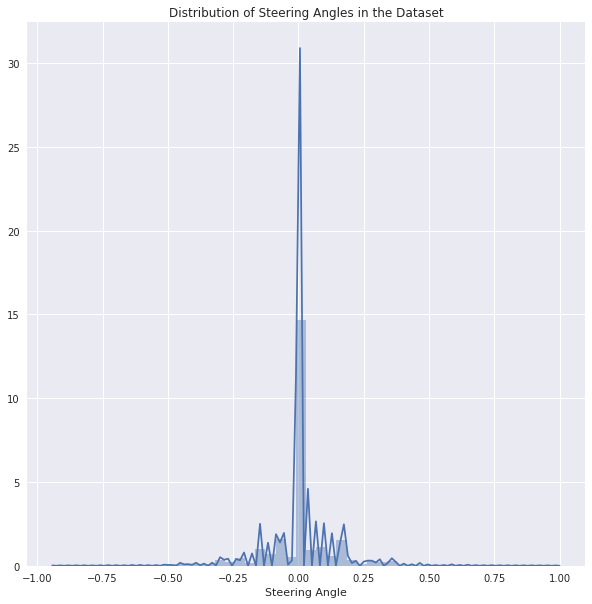

In [5]:
# Visualize the distribution of the data
sns.set(rc={'figure.figsize':(10, 10)})
fig = sns.distplot(data_df.steering)
plt.xlabel("Steering Angle")
plt.title("Distribution of Steering Angles in the Dataset")
plt.show(fig);

The Sample Dataset is skewed toward the zero steering angle and therefore more training data will need to be added during the Data Preprocessing step.

---
## Data Preprocesing
### Feature Extraction

In [6]:
# Separate the features
X = data_df[['center', 'left', 'right']].values
y = data_df['steering'].values

### Training/Validation Datsets
Using a 90/10 split, the dataset is separated to 90% for Training and 10% for Validation. The final test onm the datset will be handled by the simulator.

In [7]:
# Create Training and Validation datasets
X_sample, X_valid, y_sample, y_valid = train_test_split(X, y, test_size=0.1, random_state=42)

### Image TRansformations
1. Crop images for Region of Interest (ROI).
2. Resize images to $66 \times 200 \times 3$.
3. Convert to YUV Channels per the NVidia model.

In [8]:
# Image Transofmrations
def crop(image):
    """
    Crop the image (removing the sky at the top and the car front at the bottom)
    """
    return image[60:-25, :, :] # remove the sky and the car front

def resize(image):
    """
    Resize the image to the input shape used by the network model
    """
    return cv2.resize(image, (IMAGE_WIDTH, IMAGE_HEIGHT), cv2.INTER_AREA)

def rgb2yuv(image):
    """
    Convert the image from RGB to YUV
    """
    return cv2.cvtColor(image, cv2.COLOR_RGB2YUV)

### Image Augmentation
- Randomly choose right, left or center images.
- For left image, steering angle is adjusted by +0.2
- For right image, steering angle is adjusted by -0.2
- Randomly flip image left/right
- Randomly translate image horizontally with steering angle adjustment (0.002 per pixel shift)
- Randomly translate image virtically
- Randomly added shadows
- Randomly altering image brightness (lighter or darker)
- Randonly apply distortions

In [9]:
# Randomly Flip image Left/Right
def flip(image, steering_angle):
    """
    Randomly flit the image left <-> right, and adjust the steering angle.
    """
    if np.random.rand() < 0.5:
        image = cv2.flip(image, 1)
        steering_angle = -steering_angle
    return image, steering_angle

In [10]:
# Randomly Translate Vertically and Horizontally
def translate(image, steering_angle, range_x, range_y):
    """
    Randomly shift the image virtially and horizontally (translation).
    """
    trans_x = range_x * (np.random.rand() - 0.5)
    trans_y = range_y * (np.random.rand() - 0.5)
    steering_angle += trans_x * 0.002
    trans_m = np.float32([[1, 0, trans_x], [0, 1, trans_y]])
    height, width = image.shape[:2]
    image = cv2.warpAffine(image, trans_m, (width, height))
    return image, steering_angle

In [11]:
def distort(image):
    ''' 
    method for adding random distortion to dataset images, including random brightness adjust, and a random
    vertical shift of the horizon position
    '''
    new_img = image.astype(float)
    # random brightness - the mask bit keeps values from going beyond (0,255)
    value = np.random.randint(-28, 28)
    if value > 0:
        mask = (new_img[:,:,0] + value) > 255 
    if value <= 0:
        mask = (new_img[:,:,0] + value) < 0
    new_img[:,:,0] += np.where(mask, 0, value)
    # random shadow - full height, random left/right side, random darkening
    h,w = new_img.shape[0:2]
    mid = np.random.randint(0,w)
    factor = np.random.uniform(0.6,0.8)
    if np.random.rand() > .5:
        new_img[:,0:mid,0] *= factor
    else:
        new_img[:,mid:w,0] *= factor
    # randomly shift horizon
    h,w,_ = new_img.shape
    horizon = 2*h/5
    v_shift = np.random.randint(-h/8,h/8)
    pts1 = np.float32([[0,horizon],[w,horizon],[0,h],[w,h]])
    pts2 = np.float32([[0,horizon+v_shift],[w,horizon+v_shift],[0,h],[w,h]])
    M = cv2.getPerspectiveTransform(pts1,pts2)
    new_img = cv2.warpPerspective(new_img,M,(w,h), borderMode=cv2.BORDER_REPLICATE)
    return new_img.astype(np.uint8)

In [12]:
# Radomly Adjust Brightness
def brightness(image):
    """
    Randomly adjust brightness of the image.
    """
    # HSV (Hue, Saturation, Value) is also called HSB ('B' for Brightness).
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    ratio = 1.0 + 0.4 * (np.random.rand() - 0.5)
    hsv[:,:,2] =  hsv[:,:,2] * ratio
    return cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

In [13]:
def load(data_dir, image_file):
    """
    Load RGB images from a file
    """
    return mpimg.imread(os.path.join(data_dir, image_file.strip()))

def choose(data_dir, center, left, right, steering_angle):
    """
    Randomly choose an image from the center, left or right, and adjust
    the steering angle.
    """
    choice = np.random.choice(3)
    if choice == 0:
        return load(data_dir, left), steering_angle + 0.2
    elif choice == 1:
        return load(data_dir, right), steering_angle - 0.2
    return load(data_dir, center), steering_angle

def transform(image):
    """
    Combine all preprocess functions into one
    """
    image = crop(image)
    image = resize(image)
    image = rgb2yuv(image)
    return image

### Augmented Image Examples

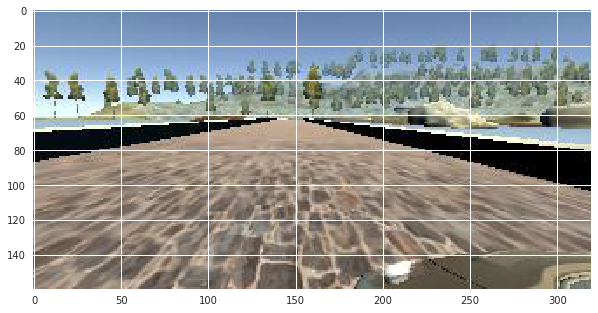

In [14]:
# Origional 'left' image
IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS = 66, 200, 3
INPUT_SHAPE = (IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS)
random_image = X[100][1]
img = load('data', random_image)
plt.imshow(img);

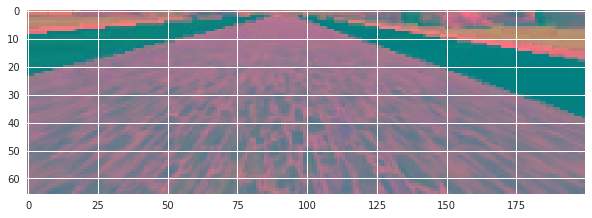

In [15]:
# Preprocessed "original" image
plt.imshow(transform(img));

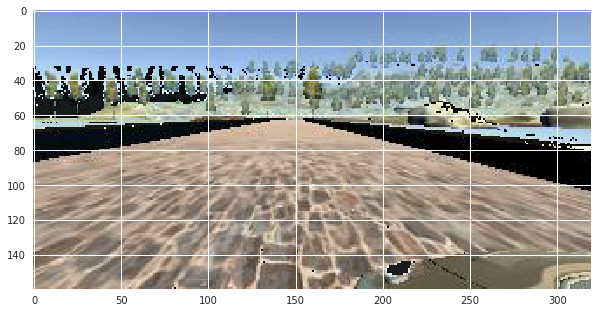

In [16]:
# Add Random brightness
plt.imshow(brightness(img));

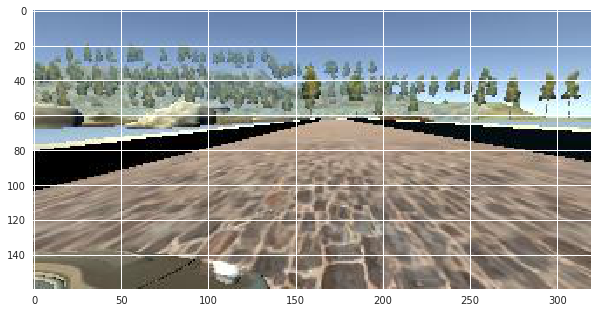

In [17]:
# Flip
plt.imshow(flip(img, 0)[0]);

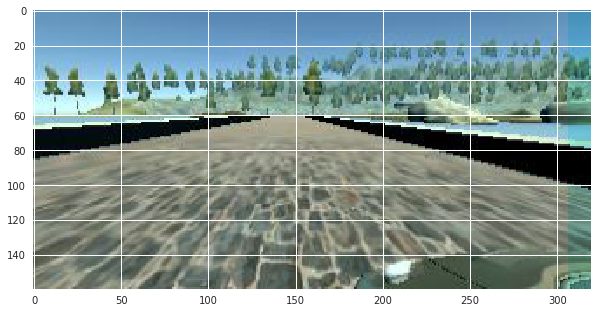

In [18]:
# Distort
plt.imshow(distort(img));

### Training and Validation Dataset
Create the Training and Vlaidation Datasets using a 90/10 split respectivley. There is no Test Dataset as the final test will be acomplished using the Simulator.

In [19]:
# Batch Image Generator
HEIGHT, WIDTH, CHANNELS = 66, 200, 3
INPUT_SHAPE = (HEIGHT, WIDTH, CHANNELS)

def augument(data_dir, center, left, right, steering_angle, range_x=100, range_y=10):
    """
    Generate an augumented image and adjust steering angle.
    (The steering angle is associated with the center image)
    """
    image, steering_angle = choose(data_dir, center, left, right, steering_angle)
    image, steering_angle = flip(image, steering_angle)
    image, steering_angle = translate(image, steering_angle, range_x, range_y)
    image = brightness(image)
    image = distort(image)
    return image, steering_angle


def aug_pipeline(data_dir, image_paths, steering_angles, batch_size, is_training):
    """
    Generate training image give image paths and associated steering angles
    """
    images = np.empty([batch_size, HEIGHT, WIDTH, CHANNELS])
    steering = np.empty(batch_size)
    while True:
        i = 0
        for index in np.random.permutation(image_paths.shape[0]):
            center, left, right = image_paths[index]
            steering_angle = steering_angles[index]
            # argumentation
            if is_training and np.random.rand() < 0.9:
                image, steering_angle = augument(data_dir, center, left, right, steering_angle)
            else:
                image = load(data_dir, center) 
            # add the image and steering angle to the batch
            images[i] = transform(image)
            steering[i] = steering_angle
            i += 1
            if i == batch_size:
                break
        return np.array(images).astype(np.float32), np.array(steering).astype(np.float32)

In [20]:
X_train, y_train = aug_pipeline('data', X_sample, y_sample, len(X_sample), True)
X_valid, y_valid = aug_pipeline('data', X_valid, y_valid, len(X_valid), False)

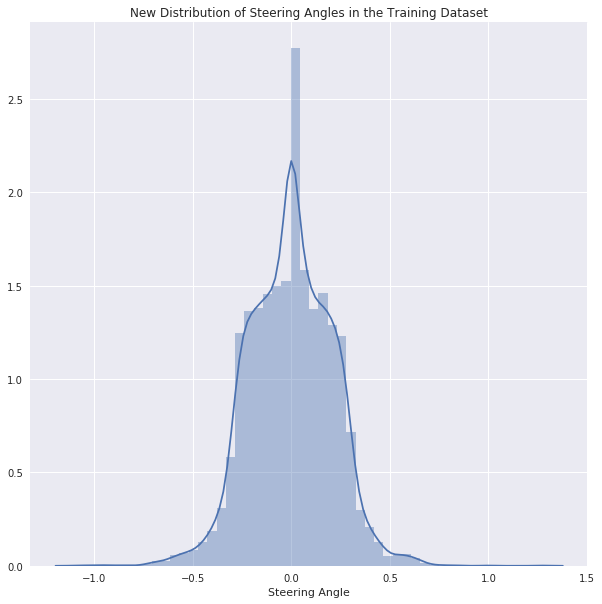

In [21]:
# Plot New Distribution of training examples
fig = sns.distplot(y_train)
plt.xlabel("Steering Angle")
plt.title("New Distribution of Steering Angles in the Training Dataset")
plt.show(fig);

As can be seen from the sample datatset, the disribution of steering angles is more uniform. Next we create the datasets for the model. (upload them to S3)

---
## Model Architecture and Training
[End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/deep-learning-self-driving-cars/)
![Architecture](https://devblogs.nvidia.com/parallelforall/wp-content/uploads/2016/08/cnn-architecture-624x890.png)

```python
# Reshape images for Gluon CNN
X_train = X_train.reshape(-1, 3, 66, 200)
y_train = y_train.reshape(-1, 1)
X_valid = X_valid.reshape(-1, 3, 66, 200)
y_valid = y_valid.reshape(-1, 1)
```

```python
# Create Preprocessed Training and Valiudation Datasets
train_data = mx.gluon.data.DataLoader(
    mx.gluon.data.ArrayDataset(
        X_train,
        y_train
    ),
    shuffle=True,
    batch_size=64
)
test_data = mx.gluon.data.DataLoader(
    mx.gluon.data.ArrayDataset(
        X_valid,
        y_valid
    ),
    shuffle=False,
    batch_size=64
)
```

In [24]:
# Create the Nvidia Model
ctx = mx.cpu()
net = gluon.nn.Sequential()
with net.name_scope():
    net.add(gluon.nn.Lambda(lambda x: x/127.5-1.0)) #Normalization
    net.add(gluon.nn.Conv2D(
        channels=24,
        kernel_size=(5, 5),
        strides=(2, 2),
        padding=1
    ))
    net.add(gluon.nn.Activation('relu'))
    net.add(gluon.nn.Conv2D(
        channels=36,
        kernel_size=(5, 5),
        strides=(2, 2),
        padding=1
    ))
    net.add(gluon.nn.Activation('relu'))
    net.add(gluon.nn.Conv2D(
        channels=48,
        kernel_size=(5, 5),
        strides=(2, 2),
        padding=1
    ))
    net.add(gluon.nn.Activation('relu'))
    net.add(gluon.nn.Conv2D(
        channels=64,
        kernel_size=3
    ))
    net.add(gluon.nn.Activation('relu'))
    net.add(gluon.nn.Conv2D(
        channels=64,
        kernel_size=3
    ))
    net.add(gluon.nn.Activation('relu'))
    net.add(gluon.nn.Dropout(.5))
    net.add(gluon.nn.Flatten())
    net.add(gluon.nn.Dense(1164))
    net.add(gluon.nn.Activation('relu'))
    net.add(gluon.nn.Dense(100))
    net.add(gluon.nn.Activation('relu'))
    net.add(gluon.nn.Dense(50))
    net.add(gluon.nn.Activation('relu'))
    net.add(gluon.nn.Dense(10))
    net.add(gluon.nn.Activation('relu'))
    net.add(gluon.nn.Dense(1))
net.hybridize()

In [25]:
# Model plot
#net.collect_params().initialize()
#x = mx.sym.var('data')
#sym = net(x)
#mx.viz.plot_network(sym)

In [26]:
def evaluate_accuracy(data_iterator, net):
    acc = mx.metric.Accuracy()
    for i, (data, label) in enumerate(data_iterator):
        data = data.as_in_context(ctx)
        label = label.as_in_context(ctx)
        output = net(data)
        predictions = nd.argmax(output, axis=1)
        acc.update(preds=predictions, labels=label)
    return acc.get()[1]

```python
net.collect_params().initialize(mx.init.Xavier(magnitude=2.24), ctx=ctx)
```

```python
rmse = gluon.loss.L2Loss()
#softmax = gluon.loss.SoftmaxCrossEntropyLoss()
```

```python
trainer = gluon.Trainer(net.collect_params(), 'Adam', {'learning_rate': 1.0e-4})
```

```python
epochs = 10
total_loss = []
for e in range(epochs):
    for i, (data, label) in enumerate(train_data):
        data = data.as_in_context(ctx)
        label = label.as_in_context(ctx)
        with autograd.record():
            output = net(data)
            loss = rmse(output, label)
        loss.backward()
        trainer.step(data.shape[0])
        curr_loss = nd.mean(loss).asscalar()
    val_accuracy = evaluate_accuracy(test_data, net)
    train_accuracy = evaluate_accuracy(train_data, net)
    total_loss.append(curr_loss)
    print("Epoch {}. Loss: {}; Training Accuracy = {}; Validation Accuracy = {}".format(
        e, curr_loss, train_accuracy, val_accuracy
        )
    )

x_axis = np.linspace(0, epochs, len(total_loss), endpoint=True)
plt.semilogy(x_axis, total_loss)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()
```

---

In [33]:
# Create Training and Validation datasets
X_sample, X_valid, y_sample, y_valid = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, y_train = aug_pipeline('data', X_sample, y_sample, len(X_sample), True)
X_valid, y_valid = aug_pipeline('data', X_valid, y_valid, len(X_valid), False)

# Reshape images for Gluon CNN
X_train = X_train.reshape(-1, 3, 66, 200)
y_train = y_train.reshape(-1, 1)
X_valid = X_valid.reshape(-1, 3, 66, 200)
y_valid = y_valid.reshape(-1, 1)

# Create Preprocessed Training and Valiudation Datasets
train_data = mx.gluon.data.DataLoader(
    mx.gluon.data.ArrayDataset(
        X_train,
        y_train
    ),
    shuffle=True,
    batch_size=64
)
test_data = mx.gluon.data.DataLoader(
    mx.gluon.data.ArrayDataset(
        X_valid,
        y_valid
    ),
    shuffle=False,
    batch_size=64
)

epochs = 10
square_loss = gluon.loss.L2Loss()
net.collect_params().initialize(mx.init.Normal(sigma=1), force_reinit=True, ctx=ctx)
trainer = gluon.Trainer(net.collect_params(), 'adam', {'learning_rate': 1.0e-4})
train_data = mx.gluon.data.DataLoader(
    mx.gluon.data.ArrayDataset(
        X_train,
        y_train
    ),
    shuffle=True,
    batch_size=64
)
test_data = mx.gluon.data.DataLoader(
    mx.gluon.data.ArrayDataset(
        X_valid,
        y_valid
    ),
    shuffle=False,
    batch_size=64
)

total_loss = []
val_acc = []
train_acc = []

for epoch in range(epochs):
    for i, (data, label) in enumerate(train_data):
        data = data.as_in_context(ctx)
        label = label.as_in_context(ctx)
        with autograd.record():
            output = net(data)
            loss = square_loss(output, label)
        loss.backward()
        trainer.step(data.shape[0])
        curr_loss = nd.mean(loss).asscalar()
    val_accuracy = evaluate_accuracy(test_data, net)
    val_acc.append(val_accuracy)
    train_accuracy = evaluate_accuracy(train_data, net)
    train_acc.append(train_accuracy)
    total_loss.append(curr_loss)
    print("Epoch {}. Loss: {}; Training Accuracy = {}; Validation Accuracy = {}".format(
        epoch, curr_loss, train_accuracy, val_accuracy
        )
    )

Epoch 0. Loss: 1.8113189629237658e+19; Training Accuracy = 0.9997234513274337; Validation Accuracy = 1.0
Epoch 1. Loss: 1.0440058618802864e+19; Training Accuracy = 0.9997234513274337; Validation Accuracy = 1.0
Epoch 2. Loss: 5.995331242030006e+18; Training Accuracy = 0.9997234513274337; Validation Accuracy = 1.0
Epoch 3. Loss: 3.497942861897269e+18; Training Accuracy = 0.9997234513274337; Validation Accuracy = 1.0
Epoch 4. Loss: 3.1239648724301906e+18; Training Accuracy = 0.9997234513274337; Validation Accuracy = 1.0
Epoch 5. Loss: 3.277030085156143e+18; Training Accuracy = 0.9997234513274337; Validation Accuracy = 1.0
Epoch 6. Loss: 2.4591932703291474e+18; Training Accuracy = 0.9997234513274337; Validation Accuracy = 1.0
Epoch 7. Loss: 1.8276715870468178e+18; Training Accuracy = 0.9997234513274337; Validation Accuracy = 1.0
Epoch 8. Loss: 2.0712999991398892e+18; Training Accuracy = 0.9997234513274337; Validation Accuracy = 1.0
Epoch 9. Loss: 1.420860531106906e+18; Training Accuracy = 

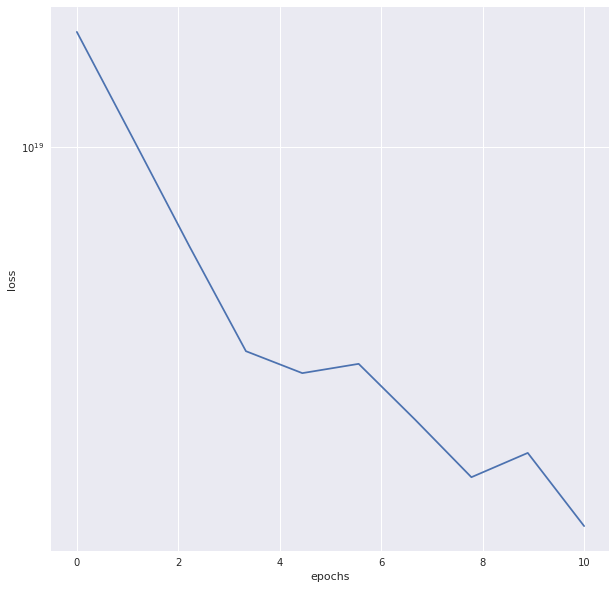

In [36]:
# Plot Loss
x_axis = np.linspace(0, epochs, len(total_loss), endpoint=True)
plt.semilogy(x_axis, total_loss)
#plt.semilogy(x_axis, val_acc)
#plt.semilogy(x_axis, train_acc)
plt.xlabel('epochs')
#plt.ylabel('loss/accuracy')
plt.ylabel('loss')
#plt.legend(['Loss', 'Validation Accuracy', 'Training Accuracy'])
plt.show()

---
## Model Optimization and Analysis (TBD)